<a href="https://colab.research.google.com/github/akashlevy/RRAM-DNN-Quantized/blob/main/resnet18_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup: Imports & Helper Functions**

Initial Setup

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import os
from torch.utils.data import DataLoader
import torch.quantization
from torch.quantization import QuantStub, DeQuantStub
from torch.quantization import *
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import copy
import pandas as pd
import statistics
import scipy.stats
from scipy.sparse import diags

Loading Testing and Training Data from CIFAR

In [ ]:
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root = './data',train=True,download=True,transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,batch_size=64,shuffle=True,num_workers=16,pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True,transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=False,num_workers=16,pin_memory=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified


Helper Functions

In [ ]:
class AverageMeter(object):
    #computes and stores average and current value, used in training
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

def accuracy(output, target):
    #computes top-1 accuracy
    with torch.no_grad():
        batch_size = target.size(0)

        _, pred = output.topk(1, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        correct_one = correct[:1].view(-1).float().sum(0, keepdim=True)
        return correct_one.mul_(100.0 / batch_size).item()

def print_size_of_model(model):
    #print size of model
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

def load_model(quantized_model, model):
    #loads model into object meant for quantization
    state_dict = model.state_dict()
    model = model.to('cpu')
    quantized_model.load_state_dict(state_dict)

def fuse_modules(model):
    #fuse together convolutions and other layers
    fused_model = model
    fused_model = torch.quantization.fuse_modules(
    fused_model, [["conv1", "bn1", "relu"]], inplace=True)
    for module_name, module in fused_model.named_children():
        if "layer" in module_name:
            for basic_block_name, basic_block in module.named_children():
                torch.quantization.fuse_modules(
                    basic_block, [["conv1", "bn1", "relu"], ["conv2", "bn2"]], inplace=True)
                for sub_block_name, sub_block in basic_block.named_children():
                    if sub_block_name == "downsample":
                        torch.quantization.fuse_modules(
                            sub_block, [["0", "1"]], inplace=True)

Training and Testing Funcs

In [ ]:
#local variable to plot loss to see convergence
train_losses = []
train_losses.clear()

def train(model: nn.Module, dataloader: DataLoader, num_epochs, cuda=False, q=False):
    train_losses.clear()
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.SGD(model.parameters(),lr=0.05, momentum=0.9, weight_decay=5e-4)

    #scheduler impacts loss convergence for QAT vs baseline
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[25,40], gamma=0.1)
    
    if q == True:
      scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,5,7,10,15], gamma=0.1)

    model.train()
    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = AverageMeter('loss')
        acc = AverageMeter('train_acc')
        for i, data in enumerate(dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            if cuda:
              inputs = inputs.cuda()
              labels = labels.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            if epoch>=3 and q:
              model.apply(torch.quantization.disable_observer)

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss.update(loss.item(), outputs.shape[0])
            acc.update(accuracy(outputs, labels), outputs.shape[0])
            if i % 100 == 0:    # print every 100 mini-batches
                print('[%d, %5d] ' %
                    (epoch + 1, i + 1), running_loss, acc)
        train_loss = running_loss.avg / len(trainloader)
        train_losses.append(train_loss)
        scheduler.step()
    print('Finished Training')


def test(model: nn.Module, dataloader: DataLoader, cuda=False) -> float:
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data

            if cuda:
              inputs = inputs.cuda()
              labels = labels.cuda()

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return 100 * correct / total

# **Train Unquantized ResNet-18 Model on CIFAR10**

Train baseline (modified) ResNet18 on CIFAR-10

In [ ]:
#get unquantized model from torch.models.quantization (already has built-in fusing capability)
unquant_model = models.quantization.resnet18(pretrained=False, num_classes=10)

#change the initial conv/maxpool layers so that they work better for CIFAR-10 dataset
unquant_model.conv1 = torch.nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1,bias=False)
unquant_model.maxpool = torch.nn.Identity()

#train
unquant_model = unquant_model.cuda()
train(unquant_model,trainloader,50,cuda=True,q=False)

#plot loss
%matplotlib inline
plt.plot(train_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

Compute baseline inference accuracy and save model.

In [ ]:
unquant_model = unquant_model.cuda()

score = test(unquant_model, testloader, cuda=True)
print('Accuracy of the network on the test images: {}% - FP32'.format(score))

torch.save(unquant_model.state_dict(), 'resnet18_cifar10_baseline.pth')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy of the network on the test images: 93.57% - FP32


# **Quantization Aware Training: 8 bits**

Initialize model and fuse.

In [ ]:
#initialize model with same modifications as baseline
qnet = models.quantization.resnet18(pretrained=False, num_classes=10)
qnet.conv1 = torch.nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1,bias=False)
qnet.maxpool = torch.nn.Identity()

qnet.load_state_dict(torch.load('resnet18_cifar10_baseline.pth'))

#fuse model
qnet.fuse_model()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Prepare for QAT, and train neural network.

In [ ]:
print(qnet)

#set for QAT
qnet.eval()
qnet.qconfig = torch.quantization.get_default_qat_qconfig()

#prepare network for QAT
qnet.train()
torch.quantization.prepare_qat(qnet,inplace=True)
qnet = qnet.cuda()

#Train NN
train(qnet,trainloader,20,cuda=True,q=True)
print("Size of Model after quantization")
print_size_of_model(qnet)

Plot loss to confirm convergence.

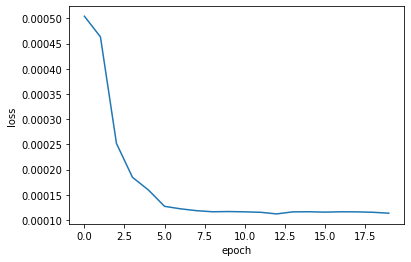

In [ ]:
%matplotlib inline
plt.plot(train_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

Convert quantized model to int8 representation and compute inference accuracy.

In [ ]:
qnet= qnet.cpu()
torch.quantization.convert(qnet,inplace=True)
print("Size of model after quantization")
print_size_of_model(qnet)

#calculate inference accuracy
score = test(qnet,testloader,cuda=False)
print('Accuracy of the fused and quantized network (trained quantized) on the test images: {}% - INT8'.format(score))

Save model.

In [ ]:
torch.save(qnet.state_dict(), 'resnet18_cifar10_8b_qat.pth')

Load saved model.

In [ ]:
qnet_plt = models.quantization.resnet18(pretrained=False, num_classes=10)
qnet_plt.conv1 = torch.nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1,bias=False)
qnet_plt.maxpool = torch.nn.Identity()

qnet_plt.train()
qnet_plt.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
qnet_plt.fuse_model()
torch.quantization.prepare_qat(qnet_plt,inplace=True)
qnet_plt = torch.quantization.convert(qnet_plt, inplace=True)

qnet_plt.load_state_dict(torch.load('resnet18_cifar10_8b_qat.pth'))

In [ ]:
score = test(qnet_plt, testloader, cuda=False)
print(score)

# **Perturb weights using Confusion Matrix Error Model**

## Preparation: Loading model and extracting weights

Load weights from saved model.

In [ ]:
model = models.quantization.resnet18(pretrained=False, num_classes=10)
model.conv1 = torch.nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1,bias=False)
model.maxpool = torch.nn.Identity()

model.train()
model.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
model.fuse_model()
torch.quantization.prepare_qat(model,inplace=True)
model = torch.quantization.convert(model, inplace=True)

model.load_state_dict(torch.load('resnet18_cifar10_8b_qat.pth'))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/torch/ao/quantization/observer.py:178: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  reduce_range will be deprecated in a future release of PyTorch."
/usr/local/lib/python3.7/dist-packages/torch/ao/quantization/utils.py:281: UserWarning: must run observer before

<All keys matched successfully>

Extract weights from model. (NOTE: need recursive method bc state_dict.items() doesn't get all layers) 

In [ ]:
weights = {}

def get_weights(model: nn.Module, key, curr_layer):
  for name, child in model.named_children():
    if isinstance(child,nn.Identity) or isinstance(child, nn.AvgPool2d) or isinstance(child, nn.quantized.QFunctional) or isinstance(child,nn.AdaptiveAvgPool2d) or isinstance(child, nn.quantized.Quantize) or isinstance(child, nn.quantized.DeQuantize):
      continue
    elif isinstance(child,nn.Sequential) or isinstance(child, torchvision.models.quantization.resnet.QuantizableBasicBlock):
      if 'layer' in name:
        curr_layer = name
      get_weights(child, name, curr_layer)
    else:
      newname = curr_layer + '.' + key + '.' + name
      weights[newname] = child.weight().int_repr().flatten().numpy()

#get weights of model
get_weights(model, "", "")
print(weights.keys())

dict_keys(['..conv1', 'layer1.0.conv1', 'layer1.0.conv2', 'layer1.1.conv1', 'layer1.1.conv2', 'layer2.0.conv1', 'layer2.0.conv2', 'layer2.downsample.0', 'layer2.1.conv1', 'layer2.1.conv2', 'layer3.0.conv1', 'layer3.0.conv2', 'layer3.downsample.0', 'layer3.1.conv1', 'layer3.1.conv2', 'layer4.0.conv1', 'layer4.0.conv2', 'layer4.downsample.0', 'layer4.1.conv1', 'layer4.1.conv2', 'layer4..fc'])


## Perturb weights using confusion matrix error model.

**Regular weight perturbation.**

In [ ]:
depositivize = np.vectorize(lambda x : x - 1 if x > 127 else x)

for seed in range(3,4):
  np.random.seed(seed)
      
  #sweep BERs
  for ber in 10.**np.linspace(-8,0,50):
    #log
    print(f'Doing {seed}\t{ber}')

    nrows = 4
    ncols = 4
    
    #create confmat
    offset = [-1, 0, 1]
    k = [[ber]*(ncols-1), [1 - 2*ber]*ncols, [ber]*(ncols-1)]

    #sparse matrix with diagonals given by k
    confmat = diags(k,offset).toarray()
    confmat[0][0] = 1-ber
    confmat[nrows-1][ncols-1] = 1-ber
    
    C_intermed = np.kron(confmat, confmat)
    C = np.kron(C_intermed, C_intermed)
    
    print(len(C))
    print(len(C[0]))

    weights_perturb = {}

    #perturb weights under confmat error model
    for layer_name in weights:
      if 'conv' in layer_name:
        weight_in_layer = weights[layer_name]

        #perturb based on confusion matrix

        weights_perturb[layer_name] = np.zeros_like(weights[layer_name])
        for x in range(256):
          perturb = np.random.choice(256, p=C[x], size=len(weights[layer_name]))
          weights_perturb[layer_name] += np.where(weights[layer_name] == (x-127), 1, 0) * perturb

        #scale back to weight value
        weights_perturb[layer_name] = depositivize(weights_perturb[layer_name] - 127)

    #load relaxed weights back into model
    for layer_name in weights_perturb:
      name_arr = layer_name.split('.')
      if name_arr[1] is " " or name_arr[1] is "":
        name_arr[1] = ""
      else:
        name_arr[1] = "[" + name_arr[1] + "]."

      if layer_name == "..conv1":
        layer_name_p = "conv1.weight"
      else:
        layer_name_p = layer_name + ".weight"

      #keep scales/zero points
      tmp = model.state_dict()[layer_name_p]
      scales = tmp.q_per_channel_scales()
      zero_pts = tmp.q_per_channel_zero_points()
      axis = tmp.q_per_channel_axis()

      new_w = torch._make_per_channel_quantized_tensor(torch.from_numpy(weights_perturb[layer_name]), scales, zero_pts, axis)
        
      setattr(model, str(str(name_arr[0] + name_arr[1] + name_arr[2]) + "weight"), new_w)

    #evaluate accuracy after relaxation
    # model = model.cuda()
    accuracy = test(model,testloader,cuda=False)

    with open('char_simple_kron_4x4_sweep_seed_4.tsv', 'a') as outf:
      print(f'{seed}\t{ber}\t{accuracy}\n')
      outf.write(f'{seed}\t{ber}\t{accuracy}\n')

**Normalized weights with respect to weight frequency.**

In [ ]:
depositivize = np.vectorize(lambda x : x - 1 if x > 127 else x)

for seed in range(1):
  np.random.seed(seed)
  
  #sweep indices
  for i in range(0,256):
    for j in range(0,256):
      if i == j:
        continue
      
      #sweep BERs
      ber = 1e-2

      print(f'Doing {seed}\t{i}\t{j}')

      #create confusion matrix
      weights_perturb = {}

      #perturb weights under confmat error model
      for layer_name in weights:
        if 'conv' in layer_name:
          weight_in_layer = weights[layer_name]

          #get unique weights and frequencies.
          unique_vals, frequencies = np.unique(weight_in_layer, return_counts=True)

          #divide ber by frequency of that particular weight
          ber = ber / (frequencies[0][j-128]) 
          
          #create confmat with new ber
          C = np.eye(256)
          C[i][i] = 1-ber
          C[i][j] = ber

          #perturb
          weights_perturb[layer_name] = np.zeros_like(weights[layer_name])
          for x in range(256):
            perturb = np.random.choice(256, p=C[x], size=len(weights[layer_name]))
            weights_perturb[layer_name] += np.where(weights[layer_name] == (x-127), 1, 0) * perturb

          #scale back to weight value
          weights_perturb[layer_name] = depositivize(weights_perturb[layer_name] - 127)

      #load relaxed weights back into model
      for layer_name in weights_perturb:
        name_arr = layer_name.split('.')
        if name_arr[1] is " " or name_arr[1] is "":
          name_arr[1] = ""
        else:
          name_arr[1] = "[" + name_arr[1] + "]."

        if layer_name == "..conv1":
          layer_name_p = "conv1.weight"
        else:
          layer_name_p = layer_name + ".weight"

        #keep scales/zero points
        tmp = model.state_dict()[layer_name_p]
        scales = tmp.q_per_channel_scales()
        zero_pts = tmp.q_per_channel_zero_points()
        axis = tmp.q_per_channel_axis()

        new_w = torch._make_per_channel_quantized_tensor(torch.from_numpy(weights_perturb[layer_name]), scales, zero_pts, axis)
        
        setattr(model, str(str(name_arr[0] + name_arr[1] + name_arr[2]) + "weight"), new_w)

      #evaluate accuracy after relaxation
      accuracy = test(model,testloader,cuda=False)

      with open('char_normc_weight_freq.tsv', 'a') as outf:
        print(f'{seed}\t{i}\t{j}\t{ber}\t{accuracy}\n')
        outf.write(f'{seed}\t{i}\t{j}\t{ber}\t{accuracy}\n')

**Weight perturbation but normalized c wrt PDF approximation**

In [ ]:
depositivize = np.vectorize(lambda x : x - 1 if x > 127 else x)

for seed in range(1):
  np.random.seed(seed)
  
  #sweep indices
  for i in range(0,256):
    for j in range(0,256):
      if i == j:
        continue
      
      ber = 1e-2

      print(f'Doing {seed}\t{i}\t{j}\t{ber}')

      #create confusion matrix

      #divide ber by prob given by pdf approximation
      ber = ber / (scipy.stats.norm(0,32).pdf(j))

      #create confmat with new ber    
      C = np.eye(256)
      C[i][i] = 1-ber
      C[i][j] = ber

      weights_perturb = {}

      #perturb weights under confmat error model
      for layer_name in weights:
        if 'conv' in layer_name:
          weight_in_layer = weights[layer_name]

          #perturb based on confusion matrix

          weights_perturb[layer_name] = np.zeros_like(weights[layer_name])
          for x in range(256):
            perturb = np.random.choice(256, p=C[x], size=len(weights[layer_name]))
            weights_perturb[layer_name] += np.where(weights[layer_name] == (x-127), 1, 0) * perturb

          #scale back to weight value
          weights_perturb[layer_name] = depositivize(weights_perturb[layer_name] - 127)

      #load relaxed weights back into model
      for layer_name in weights_perturb:
        name_arr = layer_name.split('.')
        if name_arr[1] is " " or name_arr[1] is "":
          name_arr[1] = ""
        else:
          name_arr[1] = "[" + name_arr[1] + "]."

        if layer_name == "..conv1":
          layer_name_p = "conv1.weight"
        else:
          layer_name_p = layer_name + ".weight"

        tmp = model.state_dict()[layer_name_p]
        scales = tmp.q_per_channel_scales()
        zero_pts = tmp.q_per_channel_zero_points()
        axis = tmp.q_per_channel_axis()

        new_w = torch._make_per_channel_quantized_tensor(torch.from_numpy(weights_perturb[layer_name]), scales, zero_pts, axis)
        
        setattr(model, str(str(name_arr[0] + name_arr[1] + name_arr[2]) + "weight"), new_w)

      #evaluate accuracy after relaxation
      accuracy = test(model,testloader,cuda=False)

      with open('char_normc_pdf_approx.tsv', 'a') as outf:
        print(f'{seed}\t{i}\t{j}\t{ber}\t{accuracy}\n')
        outf.write(f'{seed}\t{i}\t{j}\t{ber}\t{accuracy}\n')